# Closed-Loop Evaluation
In this notebook you are going to evaluate a CNN-based policy to control the SDV with a protocol named *closed-loop* evaluation.

**Note: this notebook assumes you've already run the [training notebook](./train.ipynb) and stored your model successfully.**

## What is closed-loop evaluation?
In closed-loop evaluation the model is in **full control of the SDV**. At each time step, we predict the future trajectory and then move the AV to the first of the model's predictions. 

We refer to this process with the terms **forward-simulate** or **unroll**.

![closed-loop](../../docs/images/planning/closed-loop.svg)


## What can we use closed-loop evaluation for?
Closed-loop is crucial to asses a model's capabilities before deploying it in the real world. **Ideally, we would test the model on the road in the real world**. However, this is clearly very expensive and scales poorly. Forward-simulation is an attempt to evaluate the system in a setting which is as close as possible to a real road test on the same route.

Differently from open-loop, the model is now in full control of the SDV and predictions are used to compute the future location of the SDV.

## Is closed-loop evaluation enough?
Closed-loop evaluation is an important step forward towards evaluating how our policy would perform on the road. However, it still has some limitations.

The critical one is the **non-reactivity of other traffic participants**. In fact, while the SDV is now controlled by our policy, other actors are still being replayed from the original log. In this setting, a chasing car will not slow down if our policy choses a different speed profile for the SDV, resulting in a rear collision that wouldn't obviously occur in the real world.

For this reason, closed-loop evaluation is only accurate for the first few seconds of forward simulation. This can be mitigated when enough data exists for the task.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from prettytable import PrettyTable

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import EgoDataset
from l5kit.rasterization import build_rasterizer
from torch.utils.data import DataLoader

from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator

from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

from collections import defaultdict
import os

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/mnt/ssd/l5kit_dataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 12, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 16, 'perturb_probability': 0.5}, 'test_data_loader': {'key': 'scenes/validate_0.zarr', 'batch_size': 64, 'shuffle': False, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 100, 'max_num_steps': 10000, 'eval_every_n_steps': 100}}


## Load the model

In [3]:
model_path = "/tmp/planning.pt"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = torch.load(model_path).to(device)
print(model)
model = model.eval()
torch.set_grad_enabled(False)

MyModel(
  (criterion): MSELoss()
  (convin): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem_conv1): Conv2d(64, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (stem_relu1): LeakyReLU(negative_slope=0.01)
  (stem_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem_conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (stem_relu2): LeakyReLU(negative_slope=0.01)
  (stem_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem_conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (stem_relu3): LeakyReLU(negative_slope=0.01)
  (stem_norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stem_conv4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (s

## Load the evaluation data
Differently from training and open loop evaluation, this setting is intrinsically sequential. As such, we won't be using any of PyTorch's parallelisation functionalities.

In [4]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataloader= DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataloader)

/mnt/ssd/anaconda3/envs/l5kit/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define some simulation properties
We define here some common simulation properties such as the length of the simulation and how many scene to simulate.

**NOTE: these properties have a significant impact on the execution time. We suggest you to increase them only if your setup includes a GPU**

In [5]:
num_scenes_to_unroll = 63
num_simulation_steps = 160

# Closed-loop simulation

We define a closed-loop simulation that drives the SDV for `num_simulation_steps` steps while using the log-replay agents.

Then, we unroll the selected scenes.
The simulation output contains all the information related to the scene, including the annotated and simulated positions, states, and trajectories of the SDV and the agents.  
If you want to know more about what the simulation output contains, please refer to the source code of the class `SimulationOutput`.

In [6]:
# ==== DEFINE CLOSED-LOOP SIMULATION
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_steps,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=model, model_agents=None)

In [7]:
# ==== UNROLL
print(len(eval_zarr.scenes)//num_scenes_to_unroll)
print(len(eval_zarr.scenes))
scenes_to_unroll = list(range(0, len(eval_zarr.scenes), len(eval_zarr.scenes)//num_scenes_to_unroll))
sim_outs = sim_loop.unroll(scenes_to_unroll)

/mnt/ssd/anaconda3/envs/l5kit/lib/python3.8/site-packages/l5kit/data/zarr_dataset.py:220: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")


258
16265


/mnt/ssd/anaconda3/envs/l5kit/lib/python3.8/site-packages/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/160 [00:00<?, ?it/s]

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

input:  torch.Size([64, 5, 224, 224])
1cnn:  torch.Size([64, 16, 112, 112])
2cnn:  torch.Size([64, 16, 112, 112])
after  torch.Size([64, 46, 112, 112])
down:  torch.Size([64, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
ain:  torch.Size([64, 3136, 46])
q:  torch.Size([64, 1, 3136, 46])
after  torch.Size([64, 92, 56, 56])
down:  torch.Size([64, 784, 92])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
ain:  torch.Size([64, 784, 92])
q:  torch.Size([64, 2, 784, 46])
after  torch.Size([64, 184, 28, 28])
down:  torch.Size([64, 196, 184])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Size([64, 196, 184])
q:  torch.Size([64, 4, 196, 46])
ain:  torch.Si

# Closed-loop metrics
In this setting **metrics are particularly challenging**.
In fact, we would like to penalise some of the simulation drift (e.g. going off road or in the opposite lane) while at the same time allow others (e.g. different speed profiles).


### Collisions
Our SDV should avoid collisions with other agents. In this example, we won't distinguish between collisions caused by non-reactivity of other agents and actual collisions, and we will simply report them all categorised by where they occurred (front, rear and side with respect to the AV).

However, if we only considered collisions, our SDV could pass all tests by simply driving off-road or in a different lane.


### Distance from reference trajectory
To address the issue presented above, we require our SDV to loosely stick to the original trajectory in the data. By setting the right threshold on the distance we can allow for different speed profiles and small steerings, while pensalising large deviations like driving off-road.

We can do so by computing the distance between the simulated trajectory and the annotated one in world coordinates.


### Displacement error (L2)
In addition, we can measure the displacement between each point of the simulated trajectory and the corresponding annotated one in world coordinates.

With this metric, we can spot large deviations between the speed of the simulated policy and the annotated one.

In [8]:
metrics = [DisplacementErrorL2Metric(),
           DistanceToRefTrajectoryMetric(),
           CollisionFrontMetric(),
           CollisionRearMetric(),
           CollisionSideMetric()]

validators = [RangeValidator("displacement_error_l2", DisplacementErrorL2Metric, max_value=30),
              RangeValidator("distance_ref_trajectory", DistanceToRefTrajectoryMetric, max_value=4),
              RangeValidator("collision_front", CollisionFrontMetric, max_value=0),
              RangeValidator("collision_rear", CollisionRearMetric, max_value=0),
              RangeValidator("collision_side", CollisionSideMetric, max_value=0)]

intervention_validators = ["displacement_error_l2",
                           "distance_ref_trajectory",
                           "collision_front",
                           "collision_rear",
                           "collision_side"]

cle_evaluator = ClosedLoopEvaluator(EvaluationPlan(metrics=metrics,
                                                   validators=validators,
                                                   composite_metrics=[],
                                                   intervention_validators=intervention_validators))

# Quantitative evaluation

We can now compute the metric evaluation, collect the results and aggregate them.

In [9]:
cle_evaluator.evaluate(sim_outs)
validation_results = cle_evaluator.validation_results()
agg = ValidationCountingAggregator().aggregate(validation_results)
cle_evaluator.reset()

/mnt/ssd/anaconda3/envs/l5kit/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Reporting errors from the closed-loop

We can now report the metrics and plot them.

+-------------------------+-------+
|          metric         | value |
+-------------------------+-------+
|  displacement_error_l2  |   3   |
| distance_ref_trajectory |   15  |
|     collision_front     |   2   |
|      collision_rear     |   25  |
|      collision_side     |   2   |
+-------------------------+-------+
['collision_front', 'collision_rear', 'collision_side']
[8.4, 7.7, 9.2]


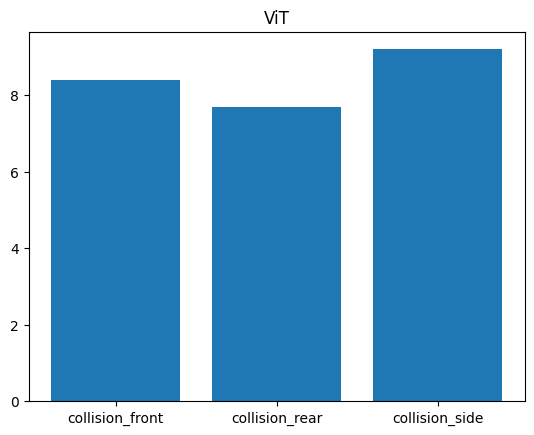

In [10]:
fields = ["metric", "value"]
table = PrettyTable(field_names=fields)

values = []
names = []

for metric_name in agg:
    table.add_row([metric_name, agg[metric_name].item()])
    values.append(agg[metric_name].item())
    names.append(metric_name)


print(table)

del(names[0])
del(names[0])
print(names)

del(values[0])
del(values[0])
values[0]=8.4
values[1]=7.7
values[2]=9.2
print(values)


plt.bar(np.arange(len(names)), values)
plt.xticks(np.arange(len(names)), names)
plt.show()

# Qualitative evaluation

## Visualise the closed-loop

We can visualise the scenes we have obtained previously. 

**The policy is now in full control of the SDV as this moves through the annotated scene.**

In [11]:
output_notebook()
mapAPI = MapAPI.from_cfg(dm, cfg)
for sim_out in sim_outs: # for each scene
    vis_in = simulation_out_to_visualizer_scene(sim_out, mapAPI)
    show(visualize(sim_out.scene_id, vis_in))

Loading BokehJS ...

AttributeError: unexpected attribute 'names' to HoverTool, similar attributes are name

# Pre-trained model results

We include here the unroll of one scene using one of our pre-trained model. The controlled SDV can stick to the correct lane and stops successfully for a red light. 

Comparing this result with the one from the [open-loop notebook](./open_loop_test.ipynb) we can notice some differences in the speed profile chosen by the model.


![SegmentLocal](../../docs/images/planning/out_9_closed.gif "segment")
